## Preprocessing and Modelling - Skenario Praktikum Modul 5

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import library

In [17]:
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import BatchNormalization, Concatenate, Dense, Dropout, Flatten, Input

from tensorflow.keras.utils import plot_model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping

import json

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
import numpy as np

from sklearn.metrics import confusion_matrix
import seaborn as sns

from keras.models import load_model

### Define path
---
dataset used here has already been downsampled for PNEUMONIA class

Click [here](https://drive.google.com/drive/folders/1RCfrglq7PkVbvGxVd86EAENzYPq4jmlU?usp=sharing) to access the dataset

#### Drive Ricky

In [ ]:
base_dir = '/content/drive/MyDrive/Dataset/chest_xray'

splitted_dir = os.path.join(base_dir, 'splitted_resampled_data')

train_dir = os.path.join(splitted_dir, 'train')
norm_train_dir = os.path.join(train_dir, 'normal')
pneu_train_dir = os.path.join(train_dir, 'pneumonia_reduced_data_count')

val_dir = os.path.join(splitted_dir, 'val')
norm_val_dir = os.path.join(val_dir, 'normal')
pneu_val_dir = os.path.join(val_dir, 'pneumonia_reduced_data_count')

test_dir = os.path.join(splitted_dir, 'test')
norm_test_dir = os.path.join(test_dir, 'normal')
pneu_test_dir = os.path.join(test_dir, 'pneumonia_reduced_data_count')

#### Drive Shofiyah

In [8]:
base_dir = '/content/drive/MyDrive/Pembelajaran Mesin/Tugas Kelompok Praktikum/Dataset/chest_xray'

splitted_dir = os.path.join(base_dir, 'splitted_data_resampling')

train_dir = os.path.join(splitted_dir, 'train')
norm_train_dir = os.path.join(train_dir, 'normal')
pneu_train_dir = os.path.join(train_dir, 'pneumonia_downsampled')

val_dir = os.path.join(splitted_dir, 'val')
norm_val_dir = os.path.join(val_dir, 'normal')
pneu_val_dir = os.path.join(val_dir, 'pneumonia_downsampled')

test_dir = os.path.join(splitted_dir, 'test')
norm_test_dir = os.path.join(test_dir, 'normal')
pneu_test_dir = os.path.join(test_dir, 'pneumonia_downsampled')

### Check split count

In [4]:
print("Total Training NORMAL:", len(os.listdir(norm_train_dir)))
print("Total Training PNEUMONIA:", len(os.listdir(pneu_train_dir)))
print('-'*30)
print("Total validation NORMAL:", len(os.listdir(norm_val_dir)))
print("Total validation PNEUMONIA:", len(os.listdir(pneu_val_dir)))
print('-'*30)
print("Total Testing NORMAL:", len(os.listdir(norm_test_dir)))
print("Total Testing PNEUMONIA:", len(os.listdir(pneu_test_dir)))

Total Training NORMAL: 1266
Total Training PNEUMONIA: 1266
------------------------------
Total validation NORMAL: 300
Total validation PNEUMONIA: 300
------------------------------
Total Testing NORMAL: 17
Total Testing PNEUMONIA: 17


### Check split ratio

In [5]:
train_data_count = len(os.listdir(norm_train_dir)) + len(os.listdir(pneu_train_dir))
val_data_count = len(os.listdir(norm_val_dir)) + len(os.listdir(pneu_val_dir))
test_data_count = len(os.listdir(norm_test_dir)) + len(os.listdir(pneu_test_dir))
total_data_count = train_data_count + val_data_count + test_data_count

print("Persentase Pembagian Data:")
print(f"\ttrain = {train_data_count / total_data_count * 100:.0f} %")
print(f"\tval = {val_data_count / total_data_count * 100:.0f} %")
print(f"\ttest = {test_data_count / total_data_count * 100:.0f} %")

Persentase Pembagian Data:
	train = 80 %
	val = 19 %
	test = 1 %


### Augmentation
---
run augmentation again after every use of generator

In [9]:
img_target_size = (180, 180)

train_aug = ImageDataGenerator(rotation_range=30,
                               zoom_range=0.4,
                               horizontal_flip=True
                               )

train_gen = train_aug.flow_from_directory(train_dir,
                                          class_mode='categorical',
                                          target_size=img_target_size)

val_test_aug = ImageDataGenerator()

val_gen = val_test_aug.flow_from_directory(val_dir,
                                      class_mode='categorical',
                                      target_size=img_target_size)

test_gen = val_test_aug.flow_from_directory(test_dir,
                                        class_mode=None,
                                        shuffle=False,
                                        target_size=img_target_size)

Found 2532 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 34 images belonging to 2 classes.


### First model

#### VGG19 base

In [ ]:
vgg19_base = VGG19(
    include_top=False,
    input_shape=(180, 180, 3)
    )

for layer in vgg19_base.layers:
    layer.trainable = False

80150528/80134624 [==============================] - 1s 0us/step


#### FC layer

In [ ]:
model = Sequential()

model.add(vgg19_base)

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.7))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(2, activation='softmax'))

# print(model.summary())

#### Model viz

In [ ]:
plot_model(model,
        #    to_file='model_viz.png',
           show_shapes=True,
           show_layer_names=True
           )

#### Compiling

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

#### Callback

In [ ]:
early_stop_val_acc = EarlyStopping(monitor='val_accuracy',
                          patience=3,
                          verbose=1,
                          mode='max',
                          restore_best_weights=True
                          )

#### Fitting

In [ ]:
H = model.fit(train_gen,
              validation_data=val_gen,
              epochs=150,
              verbose=1,
              callbacks=early_stop_val_acc)

Epoch 1/150
80/80 [==============================] - 306s 4s/step - loss: 0.3911 - accuracy: 0.8479 - val_loss: 0.9231 - val_accuracy: 0.7583
Epoch 2/150
80/80 [==============================] - 79s 981ms/step - loss: 0.2837 - accuracy: 0.8914 - val_loss: 0.5811 - val_accuracy: 0.8217
Epoch 3/150
80/80 [==============================] - 79s 985ms/step - loss: 0.2615 - accuracy: 0.8997 - val_loss: 0.2502 - val_accuracy: 0.9033
Epoch 4/150
80/80 [==============================] - 76s 953ms/step - loss: 0.2177 - accuracy: 0.9131 - val_loss: 0.3325 - val_accuracy: 0.8667
Epoch 5/150
80/80 [==============================] - 77s 956ms/step - loss: 0.1995 - accuracy: 0.9238 - val_loss: 0.2862 - val_accuracy: 0.8950
Epoch 6/150
80/80 [==============================] - 78s 970ms/step - loss: 0.2159 - accuracy: 0.9214 - val_loss: 0.2214 - val_accuracy: 0.9217
Epoch 7/150
80/80 [==============================] - 77s 958ms/step - loss: 0.2244 - accuracy: 0.9143 - val_loss: 0.1911 - val_accuracy: 0

#### Save model and history

In [ ]:
save_dir = '/content/drive/MyDrive/Informatika/Semester 7/Pembelajaran Mesin/Tugas Kelompok Praktikum/Skenario Praktikum/Modul 5'

json.dump(H.history, open(save_dir + '/first_model.json', 'w'))
model.save(save_dir + '/first_model.h5')

#### Acc loss plot

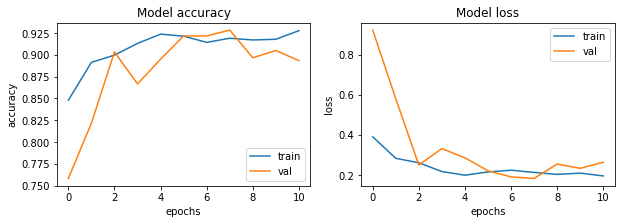

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(H.history[met])
    ax[i].plot(H.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

#### Classification report

In [ ]:
y_true = test_gen.classes

pred_result = model.predict(test_gen)
y_pred = np.argmax(pred_result, axis=-1)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94        17
           1       1.00      0.88      0.94        17

    accuracy                           0.94        34
   macro avg       0.95      0.94      0.94        34
weighted avg       0.95      0.94      0.94        34



#### Confusion matrix

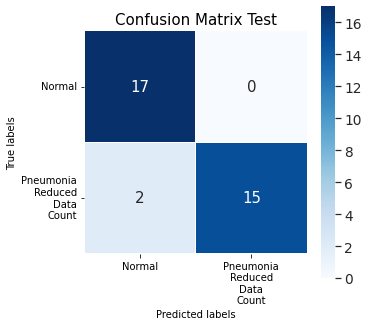

In [ ]:
labels = test_gen.class_indices
labels = [label.replace("_", "\n").title() for label in labels]

cmatrix_result = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,5))
ax = plt.subplot()

data = np.asarray(cmatrix_result).reshape(2,2)

sns.set(font_scale=1.25)
sns.heatmap(data,
            annot=True,
            ax=ax,
            cmap="Blues",
            square=True,
            linewidths=.3,
            xticklabels=labels,
            yticklabels=labels
            )

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

plt.yticks(rotation=0)
plt.title('Confusion Matrix Test')
plt.show()

### Second model

#### Pre-trained model base

In [13]:
load_dir = '/content/drive/MyDrive/Pembelajaran Mesin/Tugas Kelompok Praktikum/Skenario Praktikum/Modul 5'

model_ricky_dir = load_model(load_dir + '/model_ricky.h5')
model_shofiyah_dir = load_model(load_dir + '/model_shofiyah.h5')

for layer in model_ricky_dir.layers:
    layer.trainable = False

for layer in model_shofiyah_dir.layers:
    layer.trainable = False

model_ricky = Model(model_ricky_dir.input, model_ricky_dir.layers[2].output)
model_shofiyah = Model(model_shofiyah_dir.input, model_shofiyah_dir.layers[2].output)

#### FC layer

In [18]:
input_layer = Input((180, 180, 3))

pretrained_base_1 = Flatten()(model_ricky(input_layer))
pretrained_base_2 = Flatten()(model_shofiyah(input_layer))
pretrained_base = Concatenate()([pretrained_base_1, pretrained_base_2])

fc_layer = Flatten()(pretrained_base)
fc_layer = Dense(512, activation='relu')(fc_layer)
fc_layer = BatchNormalization()(fc_layer)
fc_layer = Dropout(0.7)(fc_layer)
fc_layer = Dense(256, activation='relu')(fc_layer)
fc_layer = BatchNormalization()(fc_layer)
fc_layer = Dropout(0.5)(fc_layer)
fc_layer = Dense(64, activation='relu')(fc_layer)
fc_layer = BatchNormalization()(fc_layer)
fc_layer = Dropout(0.3)(fc_layer)

output_layer = Dense(2, activation='softmax')(fc_layer)

model = Model(input_layer, output_layer)

#### Model viz

In [ ]:
plot_model(model,
        #    to_file='model_viz.png',
           show_shapes=True,
           show_layer_names=True
           )

#### Compiling

In [20]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

#### Callback

In [21]:
early_stop_val_acc = EarlyStopping(monitor='val_accuracy',
                          patience=3,
                          verbose=1,
                          mode='max',
                          restore_best_weights=True
                          )

#### Fitting

In [ ]:
H = model.fit(train_gen,
              validation_data=val_gen,
              epochs=150,
              verbose=1,
              callbacks=early_stop_val_acc)